# Premier modèle

## Importation des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Read the csv file
csv = pd.read_csv('./Public_Avast_CTU_CAPEv2_Dataset_Small/public_labels.csv')
df_json = pd.DataFrame()

for i in range(3001):
    # Print current index over previous
    print(str(i) + '/' + str(len(csv)), end='\r')

    sha256 = csv['sha256'][i]

    # Read the json file
    json_file = './Public_Avast_CTU_CAPEv2_Dataset_Small/public_small_reports/' + sha256 + '.json'
    
    with open(json_file) as f:
        try:
            data = json.load(f)
        except:
            print('Error: could not read the file ' + sha256 + '.json')
            continue

    # Normalize the data
    df_data = pd.json_normalize(data)
    
    # Add the sha256, classification_family, classification_type and date columns first
    df_data.insert(0, 'sha256', sha256)
    df_data.insert(1, 'classification_family', csv['classification_family'][i])
    df_data.insert(2, 'classification_type', csv['classification_type'][i])
    df_data.insert(3, 'date', csv['date'][i])
    
    # Append the data to the dataframe
    df_json = pd.concat([df_json, df_data], ignore_index=True)

# Display all the columns
pd.set_option('display.max_columns', None)
df_json.head()

Error: could not read the file 0209a4e602f63fa2c8bb1c4a3769858763545afc87753d9e0fd6eb8492b4ff1b.json


,sha256,classification_family,classification_type,date,behavior.summary.keys,behavior.summary.resolved_apis,behavior.summary.executed_commands,behavior.summary.write_keys,behavior.summary.files,behavior.summary.read_files,behavior.summary.started_services,behavior.summary.created_services,behavior.summary.write_files,behavior.summary.delete_keys,behavior.summary.read_keys,behavior.summary.delete_files,behavior.summary.mutexes,static.pe.icon_hash,static.pe.sections,static.pe.peid_signatures,static.pe.entrypoint,static.pe.exports,static.pe.overlay.offset,static.pe.overlay.size,static.pe.digital_signers,static.pe.imphash,static.pe.reported_checksum,static.pe.icon,static.pe.guest_signers.aux_error,static.pe.guest_signers.aux_sha1,static.pe.guest_signers.aux_timestamp,static.pe.guest_signers.aux_valid,static.pe.guest_signers.aux_signers,static.pe.guest_signers.aux_error_desc,static.pe.actual_checksum,static.pe.imports,static.pe.exported_dll_name,static.pe.dirents,static.pe.versioninfo,static.pe.resources,static.pe.pdbpath,static.pe.osversion,static.pe.icon_fuzzy,static.pe.imagebase,static.pe.imported_dll_count,static.pe.timestamp,static.pe.overlay
0,00003d128a7eb859f65f5780d8fa2b5e52d472665678bf...,Qakbot,banker,2019-03-20,"[HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\OLEAUT,...","[kernel32.dll.FlsAlloc, kernel32.dll.FlsGetVal...",[C:\Users\comp\AppData\Local\Temp\00003D128A7E...,[HKEY_CURRENT_USER\Software\Microsoft\Windows\...,[C:\Windows\Globalization\Sorting\sortdefault....,[C:\Windows\Globalization\Sorting\sortdefault....,[],[],[C:\Users\comp\AppData\Roaming\Microsoft\Tiafu...,[],"[DisableUserModeCallbackFilter, HKEY_LOCAL_MAC...",[C:\Users\comp\AppData\Roaming\Microsoft\Windo...,"[00003D128A7EB859F65Fa, udkyu, Global\ikkzowxr...",None,"[{'raw_address': '0x00001000', 'name': '.text'...",None,0x00404ae5,[],0x000b0000,0x000015c9,[{'extensions_cRLDistributionPoints_0': 'http:...,ef2387d2be02f95ecf1753498f46b165,0x000bfdca,None,True,None,None,False,[],No signature found. SignTool Error File not va...,0x000bfdcb,"[{'dll': 'OLEAUT32.dll', 'imports': [{'name': ...",None,"[{'name': 'IMAGE_DIRECTORY_ENTRY_EXPORT', 'vir...",[],"[{'name': 'RT_VERSION', 'filetype': None, 'off...",None,5.0,None,0x00400000,7.0,2068-03-09 10:54:33,NaN
1,0000698621e473a0828c1c957873e7d086f2d90eebc6a3...,Swisyn,trojan,2019-11-16,"[HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\OLEAUT,...","[kernel32.dll.IsProcessorFeaturePresent, kerne...",[c:\windows\system\explorer.exe],[HKEY_CURRENT_USER\Software\VB and VBA Program...,[C:\Windows\Globalization\Sorting\sortdefault....,[C:\Windows\Globalization\Sorting\sortdefault....,[],[],[C:\Users\comp\AppData\Local\Temp\~DFB053C035C...,[],[HKEY_LOCAL_MACHINE\SYSTEM\ControlSet001\Contr...,[C:\Users\comp\AppData\Local\Temp\~DFB053C035C...,[],None,"[{'raw_address': '0x00001000', 'name': '.text'...",None,0x00403670,[],0x0002e000,0x00005ba5,[],98f67c550a7da65513e63ffd998f6b2e,0x0003b1c8,None,True,None,None,False,[],No signature found. SignTool Error File not va...,0x00035c05,"[{'dll': 'MSVBVM60.DLL', 'imports': [{'name': ...",None,"[{'name': 'IMAGE_DIRECTORY_ENTRY_EXPORT', 'vir...",[],"[{'name': 'RT_ICON', 'filetype': None, 'offset...",None,4.0,None,0x00400000,1.0,2011-06-14 19:01:16,NaN
2,0000a65749f5902c4d82ffa701198038f0b4870b00a27c...,Qakbot,banker,2018-06-25,[HKEY_LOCAL_MACHINE\System\CurrentControlSet\C...,"[kernel32.dll.AddVectoredExceptionHandler, ker...","[""C:\Users\comp\AppData\Local\Temp\0000A65749F...",[HKEY_CURRENT_USER\Software\Microsoft\Windows\...,[C:\Windows\Globalization\Sorting\sortdefault....,[C:\Windows\Globalization\Sorting\sortdefault....,[],[],[C:\Users\comp\AppData\Roaming\Microsoft\Jxoqw...,[],[HKEY_LOCAL_MACHINE\SYSTEM\ControlSet001\Contr...,[C:\Users\comp\AppData\Roaming\Microsoft\Windo...,"[0000A65749F5902C4D82a, ioqul, Global\jxoqwn, ...",None,"[{'raw_address': '0x00001000', 'name': '.text'...",None,0x004027e0,[],NaN,NaN,[],43f53294b4820193ad9ce0b7a05b9456,0x00000000,None,True,None,None,False,[],No signature fo

## Split the data

In [8]:
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
from sklearn.utils import shuffle
import struct

columns = ['static.pe.osversion', 'static.pe.imported_dll_count', 'static.pe.guest_signers.aux_valid', 'static.pe.reported_checksum', 'static.pe.actual_checksum', 'static.pe.entrypoint']
X = df_json[columns].values.reshape(-1, len(columns))
y = df_json['classification_family'].values.reshape(-1, 1)

# Shuffle the data
X, y = shuffle(X, y)

def hexToDecimal(hex):
    if str(hex) == 'nan':
        return 0
    else:
        return int(str(hex), 16)

# Convert hexadecimal values reported_checksum and actual_checksum to decimal
for i in range(len(X)):
    X[i][3] = hexToDecimal(X[i][3])
    X[i][4] = hexToDecimal(X[i][4])
    X[i][5] = hexToDecimal(X[i][5])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Print shapes
print(X_train.shape)
print(X_test.shape)

# print all unique values of y
print(np.unique(y_train))

(2700, 6)
(300, 6)
['Adload' 'Emotet' 'HarHar' 'Lokibot' 'Qakbot' 'Swisyn' 'Trickbot'
 'Ursnif' 'Zeus' 'njRAT']


## Create the model

In [9]:
# Create the DT model
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

# plot_tree
#from sklearn.tree import plot_tree

#plt.figure(figsize=(100, 20))
#_ = plot_tree(dt, filled=True, fontsize=8, feature_names=['osversion', 'imported_dll_count', 'aux_valid', 'reported_checksum', 'actual_checksum', 'entrypoint'], class_names=['Adload', 'Emotet', 'HarHar', 'Lokibot', 'Qakbot', 'Swisyn', 'Trickbot',
# 'Ursnif', 'Zeus', 'njRAT'])"""

DecisionTreeClassifier()

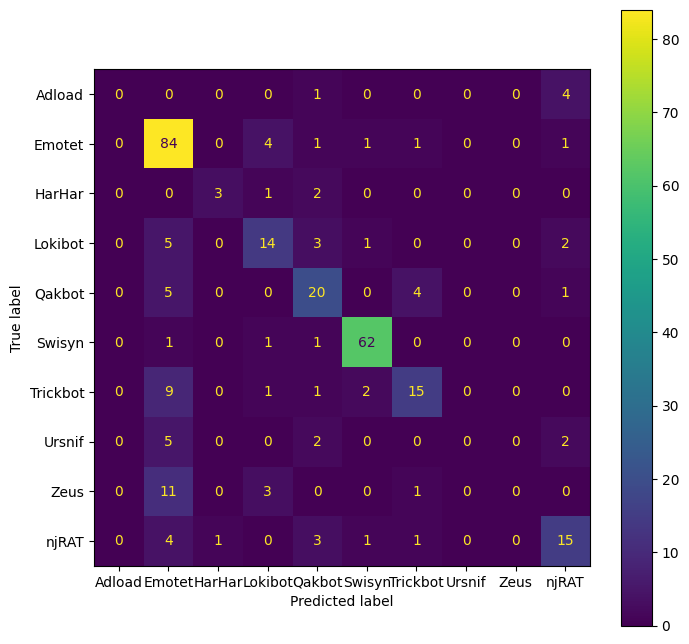

In [10]:
# Print confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

plt.rcParams['figure.figsize'] = [8, 8]
y_pred = dt.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Adload', 'Emotet', 'HarHar', 'Lokibot', 'Qakbot', 'Swisyn', 'Trickbot',
 'Ursnif', 'Zeus', 'njRAT'])
disp.plot()

In [11]:
# Display the accuracy
print("Accuracy on training set: {:.3f}".format(dt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(dt.score(X_test, y_test)))
print("\n")

# Predict
n = 0
print("Expected output: " + y_test[n][0])
print("Predicted output: " + dt.predict([X_test[n]]).item(0))

Accuracy on training set: 0.726
Accuracy on test set: 0.710


Expected output: Emotet
Predicted output: Emotet
